In [26]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spl
import scipy.stats as sps
%matplotlib inline

import ot                 
import ot.plot

# for interactive widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Replicating Results with GMM (1D)

We start with simple 1D experiments, with 
$$\mu_0 = 0.3 \mathcal{N}(0.2,0.03)+ 0.7\mathcal{N}(0.4,0.04),$$
$$\mu_1 = 0.4 \mathcal{N}(0.6,0.04)+ 0.4\mathcal{N}(0.8,0.03) + 0.2\mathcal{N}(0.3,0.02) $$

In [20]:
def densite_theorique(mu,sigma,p,x):
    '''compute the 1D GMM density with parameters (mu,sigma) and weights p  at x'''
    
    K=mu.shape[0]
    y=0
    for j in range(K):
        y+=p[j]*sps.norm.pdf(x,loc=mu[j,:],scale=sigma[j,:,:])
    return y.reshape(x.shape)

In [ ]:
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
S0  = np.array([[[.03]],[[.04]]])
K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.4,.4,.2])    
mu1 = np.array([[.6,.8,.3]]).T   
S1 = np.array([[[.04]],[[.03]],[[.02]]])
K1 = pi1.shape[0]

# GMM densities
n    = 100
x    = np.linspace(0,1,num=n)
gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

## Wasserstein

The cost matrix is the euclidian distance between points in the histogramm. IT means that we are lifting points on the x-axis

In [ ]:
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
C /= C.max() # Better to normalize ? 
G0 = ot.emd(gmm0, gmm1, C) # Earth Moving Distance -> solve Kantorovich
plt.figure(3, figsize=(7, 7))
# Display the coupling that is supported on the graph of a Monge Map !
ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0')

print(np.sum(G0*C))

## Mixture Wasserstein

$$W_2^2(\alpha,\beta) = ||m_{\alpha} - m_{\beta}||^2 + \text{Tr}\bigg(\Sigma_{\alpha} + \Sigma_{\beta} -2 \big( \Sigma_{\alpha}^{\frac{1}{2}} \Sigma_{\beta} \Sigma_{\alpha}^{\frac{1}{2}} \big)^{\frac{1}{2}} \bigg)$$

In [21]:
def GaussianW2(m0,m1,Sigma0,Sigma1):
    '''compute the quadratic Wasserstein distance between two Gaussians with means m0 and m1 and covariances Sigma0 and Sigma1'''
    Sigma00  = spl.sqrtm(Sigma0)
    Sigma010 = spl.sqrtm(Sigma00@Sigma1@Sigma00)
    d        = np.linalg.norm(m0-m1)**2+np.trace(Sigma0+Sigma1-2*Sigma010)
    return d

$$MW_2^2(\mu_0,\mu_1) = \min_{P \in U{(\pi_0,\pi_1)}} \sum{k,l} P_{k,l} W_2^2(\mu_0^k,\mu_1^k)$$ $$U{(\pi_0,\pi_1)} = \big\{P \in \mathbb{R}^{K_0 \times K_1} \quad P_{i,j} \geq 0 \quad P\mathbb{1}_{K_1} = \pi_0 \quad  P^T\mathbb{1}_{K_0} = \pi_1\big\} $$

In [22]:
def GW2(pi0,pi1,mu0,mu1,S0,S1):
    '''return the GW2 discrete map and the GW2 distance between two GMM'''
    
    K0 = mu0.shape[0]
    K1 = mu1.shape[0]
    d  = mu0.shape[1]
    S0 = S0.reshape(K0,d,d)
    S1 = S1.reshape(K1,d,d)
    C  = np.zeros((K0,K1))
    
    # First we compute the distance matrix between all Gaussians pairwise
    for k in range(K0):
        for l in range(K1):
            #print("coucou", S0[k,:,:])
            C[k,l]  = GaussianW2(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:])
    #print(C)
            
            
    # Then we compute the OT distance or OT map thanks to the OT library (Kantorovich/EMD)
    P     = ot.emd(pi0,pi1,C)         # discrete transport plan
    distGW2   = np.sum(P*C)
    return P,distGW2,C

In [ ]:
P,dist = GW2(pi0,pi1,mu0,mu1,S0,S1)
print(dist)
#P should have less than K0 + K1 - 1 components
print("Number of non zero components: {}, K0+K1-1: {}".format((P>0).sum(), K0+K1-1))
P

The optimal coupling is not of the form (Id,T)#mu0, thus we do not have directly a Transportation Map, but we cannot construct some proxy.

An optimal transport plan between $\mu_0$ and $\mu_1$ for $GW_2$ is given by
$$  \gamma (x,y) = \sum_{k,l} w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x)
\delta_{y=T_{k,l}(x)},$$
where $T_{k,l}$ is the $W_2$-optimal map between $\mu_0^k$ and $\mu_1^l$ and $w_{k,l}^\ast$ is a solution of the linear program $\inf_{w \in \Pi(\pi_0,\pi_1)} \sum_{k,l}w_{kl} W_2^2(\mu_0^k,\mu_1^l).$

Moreover, if $(X,Y)$ is distributed according to the law $\gamma$, then 
$$ T_{mean}(x) := \mathbb{E}_\gamma (Y | X=x) = \frac{\sum_{k,l}
w_{k,l}^\ast g_{m_0^k,\Sigma_0^k}(x) T_{k,l}(x)}{\sum_{k} \pi^k_{0} g_{m_0^k,\Sigma_0^k}(x)} .$$

In the following, we compute and display these two maps on a regular grid.

$$T \colon x \mapsto m_{\beta} + A(x - m_{\alpha})$$
$$A = \Sigma_{\alpha}^{-\frac{1}{2}} \big( \Sigma_{\alpha}^{\frac{1}{2}} \Sigma_{\beta} \Sigma_{\alpha}^{\frac{1}{2}} \big)^{\frac{1}{2}} \Sigma_{\alpha}^{-\frac{1}{2}}$$

This can be simplified !

In [23]:
def GaussianMap(m0,m1,Sigma0,Sigma1,x):
    '''Compute the OT map (evaluated at x) between two Gaussians 
    with means m0 and m1 and covariances Sigma0 and Sigma1 
    m0 and m1 must be 2D arrays of size 1xd
    Sigma0 and Sigma1 must be 2D arrays of size dxd
    x can be a matrix of size n x d,
    each column of x is a vector to which the function is applied'''
    
    d = Sigma0.shape[0]
    m0 = m0.reshape(1,d)
    m1 = m1.reshape(1,d)
    Sigma0 = Sigma0.reshape(d,d)
    Sigma1 = Sigma1.reshape(d,d)
    Sigma  = np.linalg.inv(Sigma0)@spl.sqrtm(Sigma0@Sigma1)
    Tx        = m1+(x-m0)@Sigma
    return Tx

Carefull understand well !!

In [24]:
def GW2_map(pi0,pi1,mu0,mu1,S0,S1,wstar,x):
    '''return the GW2 maps between two GMM on the 1D grid x'''
    n,K0,K1    = x.shape[0],mu0.shape[0],mu1.shape[0]
    T          = np.zeros((K0,K1,n))     # each Tkl = T[k,l,:] is of dimension n and correspond to the W2-map between component k of mu0 and component l of mu1
    tmpmean    = np.zeros(n)
    weightmean = np.zeros(n)
    Tmean      = np.zeros((n,n))     # averaged map on a grid 
    Tmap       = np.zeros((n,n))     # multivalued map on a grid
    
    for k in range(K0):
        for l in range(K1):
            if wstar[k,l]!=0:
                T[k,l,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,],S1[l],x).reshape(n,)
                for i in range(n):
                    Ti             = int(max(min(T[k,l,i],1),0)*99)
                    Tmap[i,Ti]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=S0[k])
                    tmpmean[i]    += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=S0[k])/densite_theorique(mu0,S0,pi0,x[i])*T[k,l,i]
                    weightmean[i] += wstar[k,l]*sps.norm.pdf(x[i],loc=mu0[k],scale=S0[k])

    tmpmean = np.uint(np.maximum(np.minimum(tmpmean,1),0)*99)
    for i in range(n):
        Tmean[i,tmpmean[i]] = weightmean[i]
    
    return Tmap,Tmean



In [ ]:
n    = 100
x    = np.linspace(0,1,num=n).reshape(n,1)

Tmap,Tmean = GW2_map(pi0,pi1,mu0,mu1,S0,S1,P,x)
plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(gmm0, gmm1, Tmap, 'Tmap')

In [ ]:
plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(gmm0, gmm1, Tmean, 'Tmean')

This map does not make much sense ....

## Barycenters

In [ ]:
def barygmmot(t):
# Barycenters for GW2
    pit = P.reshape(K0*K1,1)
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

#interact(barygmmot,t=(0.0,1.0,0.05))

In [ ]:
pit = P.reshape(K0*K1,1)
for t in [0.2,0.5,.8]:
    mut = ((1-t)*mu0+t*mu1.T).reshape(K0*K1,1)
    St = (((1-t) + t*np.sqrt(S1.T/S0))**2*S0).reshape(K0*K1,1,1)
    gmmt = densite_theorique(mut,St,pit,x)
    gmmt = gmmt/gmmt.sum()
    plt.plot(x,gmmt,label='t=%.2f' %t)
    
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend();

In [ ]:
# Barycenters for OT -> DO NOT WORK !!!!
M = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
M /= M.max()
G0 = ot.emd(gmm0, gmm1, M)
A = np.vstack((gmm0, gmm1)).T

def baryot(t):
    weights = np.array([1 - t, t])
    reg = 5*1e-4
    ott = ot.barycenter(A, M, reg, weights)
    plt.plot(x,ott)
    plt.plot(x,gmm0,'r')
    plt.plot(x,gmm1,'k')
    plt.show()

interact(baryot,t=(0.0,1.0,0.05))

In [ ]:
A = np.vstack((gmm0, gmm1)).T
for t in [0.5]:#,0.25,0.5,0.75,0.9]:
    weights = np.array([1 - t])#, t])
    reg = 1e-3
    ott = ot.barycenter(A, M, reg, weights=weights, verbose=False)
    plt.plot(x,ott,label='t=%.2f' %t)
plt.plot(x,gmm0,'b:',label='mu_0')
plt.plot(x,gmm1,'r:',label='mu_1')
plt.legend()
plt.show()

# Student

It seems that nothing has to be modified !!! Should we modify the formula ???

In [ ]:
def densite_theorique_st(mu,sigma,p,x,df=3):
    '''compute the 1D Mixture Student density with parameters (mu,sigma) and weights p  at x'''
    
    K=mu.shape[0]
    y=0
    for j in range(K):
        y+=p[j]*sps.t.pdf(x,loc=mu[j,:],scale=sigma[j,:,:], df=df)
    return y.reshape(x.shape)

In [ ]:
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
S0  = np.array([[[.03]],[[.04]]])
K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.4,.4,.2])    
mu1 = np.array([[.6,.8,.3]]).T   
S1 = np.array([[[.04]],[[.03]],[[.02]]])
K1 = pi1.shape[0]

# GMM densities
n    = 100
x    = np.linspace(0,1,num=n)
gmm0 = densite_theorique_st(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique_st(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

In [ ]:
P,dist = GW2(pi0,pi1,mu0,mu1,S0,S1)
print(dist)
#P should have less than K0 + K1 - 1 components
print("Number of non zero components: {}, K0+K1-1: {}".format((P>0).sum(), K0+K1-1))
P

In [ ]:
n    = 100
x    = np.linspace(0,1,num=n).reshape(n,1)

Tmap,Tmean = GW2_map(pi0,pi1,mu0,mu1,S0,S1,P,x)
plt.figure(3, figsize=(7, 7))
ot.plot.plot1D_mat(gmm0, gmm1, Tmap, 'Tmap')

# Convergence of MW to W (1D)

Should this be a linear Increase ???

In [ ]:
var = 0.1
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[-.5,1]]).T
S0  = np.array([[[var]],[[var]]])
K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.4,.4,.2])    
mu1 = np.array([[-0.3,.5,1.5]]).T   
S1 = np.array([[[var/2]],[[var/2]],[[var/2]]])
K1 = pi1.shape[0]

n    =500
x    = np.linspace(-1,2,num=n)

gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()


# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend()
plt.show()

In [ ]:
# first GMM
d=1  # space dimension
pi0 = np.array([.3,.7])    
mu0 = np.array([[.2,.4]]).T
S0  = np.array([[[.03]],[[.04]]])
K0  = pi0.shape[0]

# second GMM
pi1 = np.array([.4,.4,.2])    
mu1 = np.array([[.6,.8,.3]]).T   
S1 = np.array([[[.04]],[[.03]],[[.02]]])
K1 = pi1.shape[0]

# GMM densities
n    = 100
x    = np.linspace(0,1,num=n)
gmm0 = densite_theorique(mu0,S0,pi0,x)
gmm0 = gmm0/gmm0.sum()
gmm1 = densite_theorique(mu1,S1,pi1,x)
gmm1 = gmm1/gmm1.sum()

# display densities
plt.plot(x,gmm0,'b',label='mu_0')
plt.plot(x,gmm1,'r',label='mu_1')
plt.legend();

$M = max Tr(\Sigma)$, here $M = 0.04\epsilon$ thus error is bounded by $2\sqrt{2M} = 2\sqrt{2*0.04\epsilon} = $

In [ ]:
# GMM densities
n    = 100
x    = np.linspace(-1,2,num=n)
e=np.linspace(1,10,100)

dist1 = []
dist2 = []

for eps in e:
    gmm0 = densite_theorique(mu0,S0*eps,pi0,x)
    gmm0 = gmm0/gmm0.sum()
    gmm1 = densite_theorique(mu1,S1*eps,pi1,x)
    gmm1 = gmm1/gmm1.sum()

    # display densities
    #plt.plot(x,gmm0,'b',label='mu_0')
    #plt.plot(x,gmm1,'r',label='mu_1')
    #plt.legend()
    #plt.show()
    
    
    C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))
    C /= C.max() # Better to normalize ? 
    G0 = ot.emd(gmm0, gmm1, C) # Earth Moving Distance -> solve Kantorovich
    #plt.figure(3, figsize=(7, 7))
    # Display the coupling that is supported on the graph of a Monge Map !
    #ot.plot.plot1D_mat(gmm0, gmm1, G0, 'OT matrix G0')
    dist1.append(np.sum(G0*C))
    
    P,dist,_ = GW2(pi0,pi1,mu0,mu1,S0*eps,S1*eps)
    dist2.append(dist)
    diff = np.array(dist2)-np.array(dist1)

In [ ]:
#print(dist1)

In [ ]:
#print(dist2)

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1, 1)
ax.plot(e,dist1,c="r", label="W")
ax.plot(e, dist2,c="b", label="MW")
ax.legend()
#ax.set_yscale('log');
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(2, 1, 1)
ax.plot(e,diff,c="r", label="error")
ax.plot(e, 2*np.sqrt(2*var*e),c="b", label="Error bound")
ax.legend()
ax.set_yscale('log');
plt.show()

Careful, this should not varry with n !!! Understand why it moves with n !!!!

# Convergence of MW to W (2D)

# Sinkhorn

# Images (Paper)

Compare color transfer with Sinkhorn color transfer !!!!! Why does value go out of range ? 

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import sklearn.mixture    # for EM
path = '../im/'
im1 = 'renoir.jpg'
im2 = 'gauguin.jpg'

In [ ]:
def load(path,im1,im2,display=True):
    u = plt.imread(path+im1)/255
    v = plt.imread(path+im2)/255
    nru,ncu,nch = u.shape
    nrv,ncv,nch = v.shape


    if display:   
        # image display thanks to the function imshow of the pyplot library of matplotlib
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))
        axes[0].imshow(u)
        axes[0].set_title('First image: {}'.format(im1))
        axes[1].imshow(v)
        axes[1].set_title('Second image: {}'.format(im2))
        fig.tight_layout()
    return u,v,nru,ncu,nrv,ncv,nch

In [ ]:
u,v,nru,ncu,nrv,ncv,nch = load(path,im1,im2)

In [ ]:
def hist_color(u,v,nru,ncu,nrv,ncv, col=False):
    X = u.reshape((nru*ncu,3))
    Y = v.reshape((nrv*ncv,3))
    nb   = 3000
    r    = np.random.RandomState(42)
    idX  = r.randint(X.shape[0], size=(nb,)) # sample random pixels
    idY  = r.randint(Y.shape[0], size=(nb,))
    Xs   = X[idX, :]
    Ys   = Y[idY, :]
    
    if not col:
        cX= Xs
        cY= Ys
    else:
        ClassesXsubsample = col[0][idX]
        ClassesYsubsample = col[1][idY]
        cX = mu0[ClassesXsubsample,:]
        cY = mu1[ClassesYsubsample,:]

    fig  = plt.figure(2, figsize=(20, 10))
    axis = fig.add_subplot(1, 2, 1, projection="3d")
    axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=cX,s=100)
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
    axis = fig.add_subplot(1, 2, 2, projection="3d")
    axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=cY,s=100)
    axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

In [ ]:
hist_color(u,v,nru,ncu,nrv,ncv)

**Separable Optimal Transport**

BE CAREFUL: this implementation works only if u and v have the same size.

For each channel we sort the list of pixels, and we then make a monotone assginment of the lists. 

<font color=red> Unbelievable that it preserves structure !< /font>

In [ ]:
def separable_OT(u,v,nru,ncu,display=True):

    uout = np.copy(u)

    for k in range(3): # Apply 1D OT on each Channel !
        uk = u[:,:,k]
        vk = v[:,:,k]   
        uk_sort,index_u = np.sort(uk,axis=None),np.argsort(uk,axis=None)
        vk_sort,index_v = np.sort(vk,axis=None),np.argsort(vk,axis=None)
        uspecifv = np.zeros(nru*ncu)
        uspecifv[index_u] = vk_sort
        uspecifv = uspecifv.reshape(nru,ncu)
        uout[:,:,k] = uspecifv

    #Display images
    plt.figure(figsize=(7, 7))
    plt.imshow(uout)
    plt.show()

In [ ]:
separable_OT(u,v,nru,ncu)

**GMM approximation with Scikit-Learn**

In [ ]:
def GMM_clf(u,v,nru,ncu,nrv,ncv, k=10):

    X = u.reshape((nru*ncu,3))
    Y = v.reshape((nrv*ncv,3))
    ninit = 1
    K0,K1 = k,k
    gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
    pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
    ClassesX = gmmX.predict(X) 
    ProbaClassesX = gmmX.predict_proba(X) 

    gmmY = sklearn.mixture.GaussianMixture(n_components=K1, covariance_type='full',n_init=ninit).fit(Y)  # spherical or full 
    pi1,mu1,S1 = gmmY.weights_, gmmY.means_, gmmY.covariances_ 
    ClassesY = gmmY.predict(Y) 
    ProbaClassesY = gmmY.predict_proba(Y)
    
    return pi0,mu0,S0,ClassesX,ProbaClassesX,pi1,mu1,S1,ClassesY,ProbaClassesY

In [ ]:
pi0,mu0,S0,ClassesX,ProbaClassesX,pi1,mu1,S1,ClassesY,ProbaClassesY = GMM_clf(u,v,nru,ncu,nrv,ncv)
hist_color(u,v,nru,ncu,nrv,ncv,col=(ClassesX,ClassesY))

In [ ]:
# display the corresponding image segmentations
useg = mu0[ClassesX]
useg = useg.reshape((nru,ncu,3))
vseg = mu1[ClassesY]
vseg = vseg.reshape((nrv,ncv,3))
# display
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes[0].imshow(useg)
axes[0].set_title('segmentation of u')
axes[1].imshow(vseg)
axes[1].set_title('segmentation of v')
fig.tight_layout()

In [ ]:
# Compute the K0xK1 OT matrix between the members of the mixtures
wstar,dist,_ = GW2(pi0/np.sum(pi0),pi1/np.sum(pi1),mu0,mu1,S0,S1)

# Compute all Tkl maps at all points of u 
T = np.zeros((K0,K1,3,nru*ncu))
for k in range(K0):
        for l in range(K1):
            T[k,l,:,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:],X).T   
            
# Compute mean color transfer on all points
Tmeanx = np.zeros((3,nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmeanx += wstar[k,l]/pi0[k]*ProbaClassesX[:,k].T*T[k,l,:,:]
                
# Compute random color transfer on all points (random sample with posterior distribution)
Trandx = np.zeros((3,nru*ncu))
tmp = np.zeros((K0*K1,nru*ncu))
for k in range(K0):
    for l in range(K1):
        tmp[k+K0*l,:]= wstar[k,l]/pi0[k]*ProbaClassesX[:,k]
for i in range(nru*ncu):
    m = np.random.choice(K0*K1,p=tmp[:,i])
    l = m//K0
    k = m - K0*l
    Trandx[:,i] = T[k,l,:,i]        

    
# Compute best color transfer on all points (only best class for each point)
Tmaxx = np.zeros((3,nru*ncu))
normalisation = np.zeros((nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmaxx += wstar[k,l]*T[k,l,:,:]*(ClassesX==k).T
        normalisation +=wstar[k,l]*(ClassesX==k).T
Tmaxx = Tmaxx/normalisation


# Display result as an image
w=Tmeanx.T.reshape((nru,ncu,3))
wmax=Tmaxx.T.reshape((nru,ncu,3))
wrand=Trandx.T.reshape((nru,ncu,3))


#we display the images
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
axes[0].imshow(np.clip(w,0,1))
axes[0].set_title('w')
axes[1].imshow(np.clip(wrand,0,1))
axes[1].set_title('wrand')
axes[2].imshow(np.clip(wmax,0,1))
axes[2].set_title('wmax')
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow(w)
axes.set_title('w')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow((w * 255).astype(np.uint8))
axes.set_title('w')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow(np.clip(w,0,1))
axes.set_title('w')
plt.show()

In [ ]:
W = np.clip(w,0,1).reshape((nru*ncu,3))
nb   = 3000
r    = np.random.RandomState(42)
idW  = r.randint(W.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Ws   = W[idW, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Ws[:, 0], Ws[:,1],Ws[:, 2], c=Ws,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

# Image (paper Sinkhorn)

Since computing the Wasserstein distance would be far too long for the task of color transfer we offer to compute a transport using Sinkhorn Algorithm (Goal: asses quality and speed).

In [1]:
im1 = 'picasso.jpg'
im2 = 'renoirPont.jpeg'

u,v,nru,ncu,nrv,ncv,nch = load(path,im1,im2)

NameError: name 'load' is not defined

In [2]:
d = 3
N = [nru*ncu,nrv*ncv]
N

NameError: name 'nru' is not defined

In [3]:
img = imageio.imread("../im/picasso.jpg")  # RGB
img.shape
img = cv2.resize(img,(224,224))/255
plt.imshow(img)
img.shape

NameError: name 'imageio' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [5]:
import numpy as np
import torch
from random import choices
import imageio
from matplotlib import pyplot as plt
import cv2


def load_image(fname) :
    img = imageio.imread(fname)  # RGB
    img = cv2.resize(img,(224,224))
    return img / 255.         # Normalized to [0,1]

def RGB_cloud(fname, sampling, dtype=torch.FloatTensor) :
    A = load_image(fname)
    A = A[::sampling, ::sampling, :]
    return torch.from_numpy(A).type(dtype).view(-1,3)

def display_cloud(ax, x) :
    x_ = x.detach().cpu().numpy()
    ax.scatter( x_[:,0], x_[:,1], x_[:,2],
                s = 25*500 / len(x_), c = x_ )

def display_image(ax, x) :
    W = int(np.sqrt(len(x)))
    print(W)
    x_ = x.view(W,W,3).detach().cpu().numpy()
    ax.imshow( x_ )

224
224


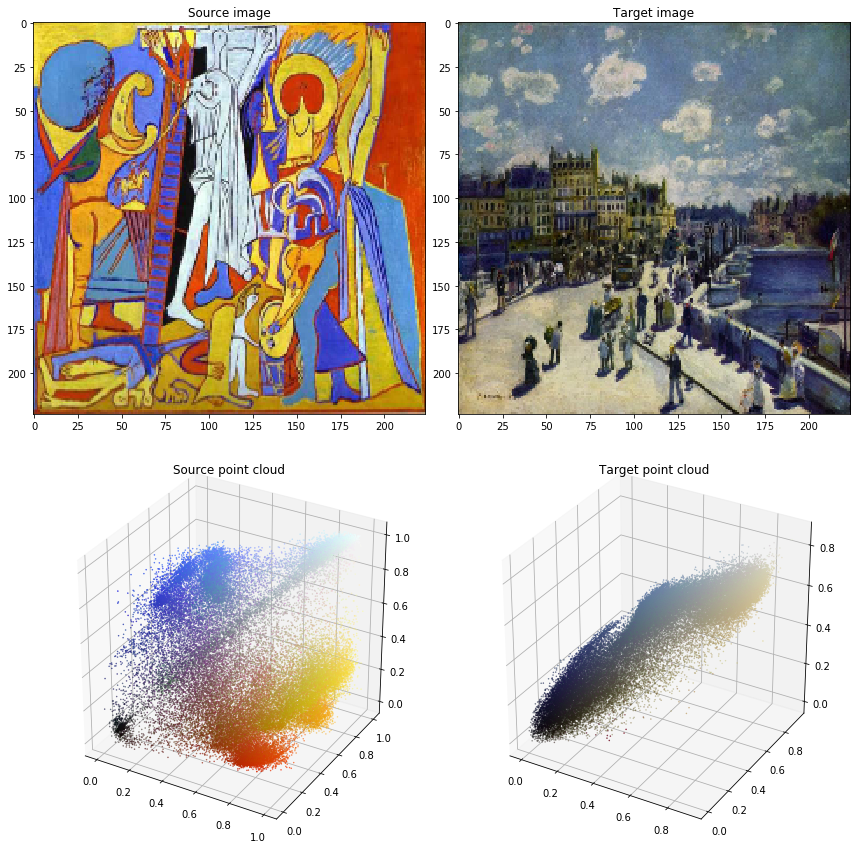

In [6]:
sampling = 8 if not use_cuda else 1
sampling = 1

X_i = RGB_cloud("../im/picasso.jpg",    sampling, dtype)
Y_j = RGB_cloud("../im/renoirPont.jpeg", sampling, dtype)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1) ; display_image(ax, X_i) ; ax.set_title("Source image")
ax = fig.add_subplot(2,2,2) ; display_image(ax, Y_j) ; ax.set_title("Target image")

ax = fig.add_subplot(2, 2, 3, projection='3d') ; display_cloud(ax, X_i) ; ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection='3d') ; display_cloud(ax, Y_j) ; ax.set_title("Target point cloud")
plt.tight_layout()

In [7]:
def color_transfer(loss, lr=1) :
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = 11
    display_its = [1, 10]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()


    plt.figure(figsize=(12,12)) ; k = 3
    ax = plt.subplot(2,2,1) ; display_image(ax, X_i) ; ax.set_title("Source image")
    plt.xticks([], []); plt.yticks([], [])
    ax = plt.subplot(2,2,2) ; display_image(ax, Y_j) ; ax.set_title("Target image")
    plt.xticks([], []); plt.yticks([], [])

    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g]  = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its : # display
            ax = plt.subplot(2,2,k) ; display_image(ax, x_i) ; ax.set_title("it = {}".format(i))
            k = k+1 ; plt.xticks([], []); plt.yticks([], [])

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g

    plt.title("it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0)/Nsteps ))
    plt.tight_layout()

224
224
Compiling libKeOpstorch07ab03cf63 in /Users/dimitri/.cache/pykeops-1.2-cpython-36//build-libKeOpstorch07ab03cf63:
       formula: Max_SumShiftExp_Reduction(( B - (P * (SqDist(X,Y) / IntCst(2)) ) ),0)
       aliases: X = Vi(0,3); Y = Vj(1,3); B = Vj(2,1); P = Pm(3,1); 
       dtype  : float32
... 

FileNotFoundError: [Errno 2] No such file or directory: 'cmake': 'cmake'

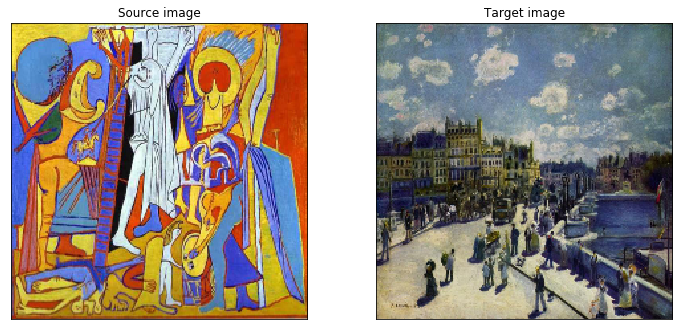

In [8]:
color_transfer( SamplesLoss("sinkhorn", blur=.3) )

# Image (own)

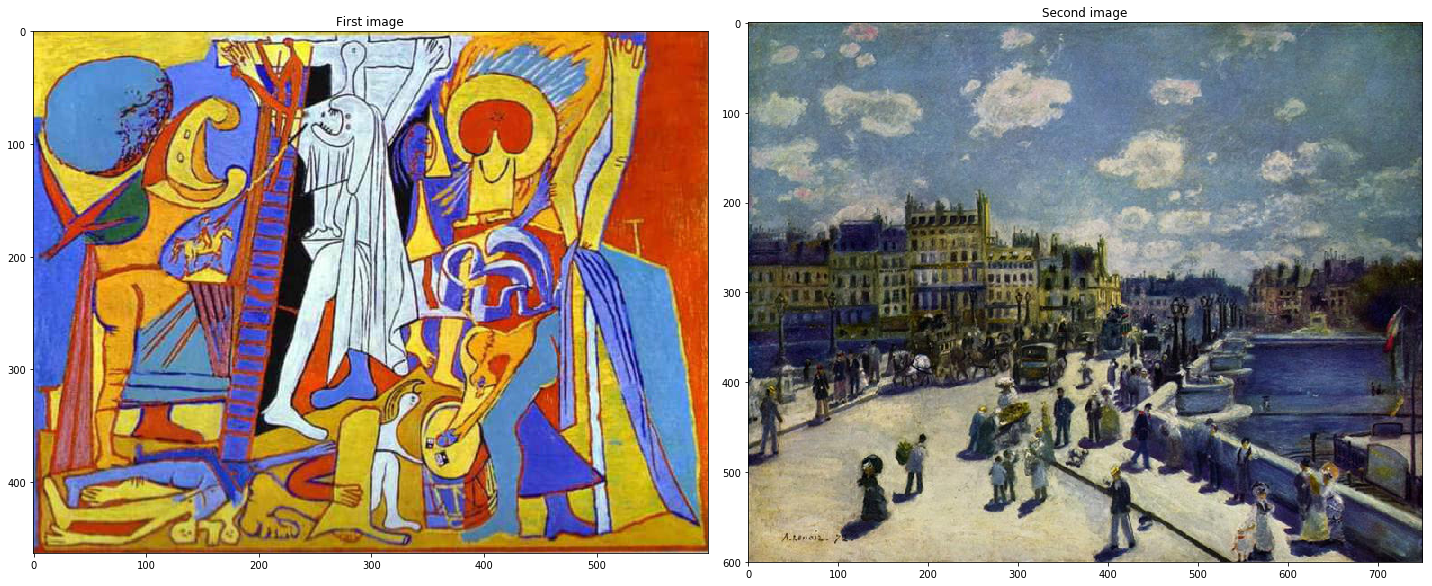

In [15]:
path = '../im/'
#u = plt.imread(path+'picasso.jpg')/255
u = plt.imread(path+'picasso.jpg')/255
#u = np.stack((u,u,u), axis=2)
v = plt.imread(path+'renoirPont.jpeg')/255
nru,ncu,nch = u.shape
nrv,ncv,nch = v.shape

# image display thanks to the function imshow of the pyplot library of matplotlib
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20))

#we display the images
axes[0].imshow(u)
axes[0].set_title('First image')
axes[1].imshow(v)
axes[1].set_title('Second image')
fig.tight_layout()

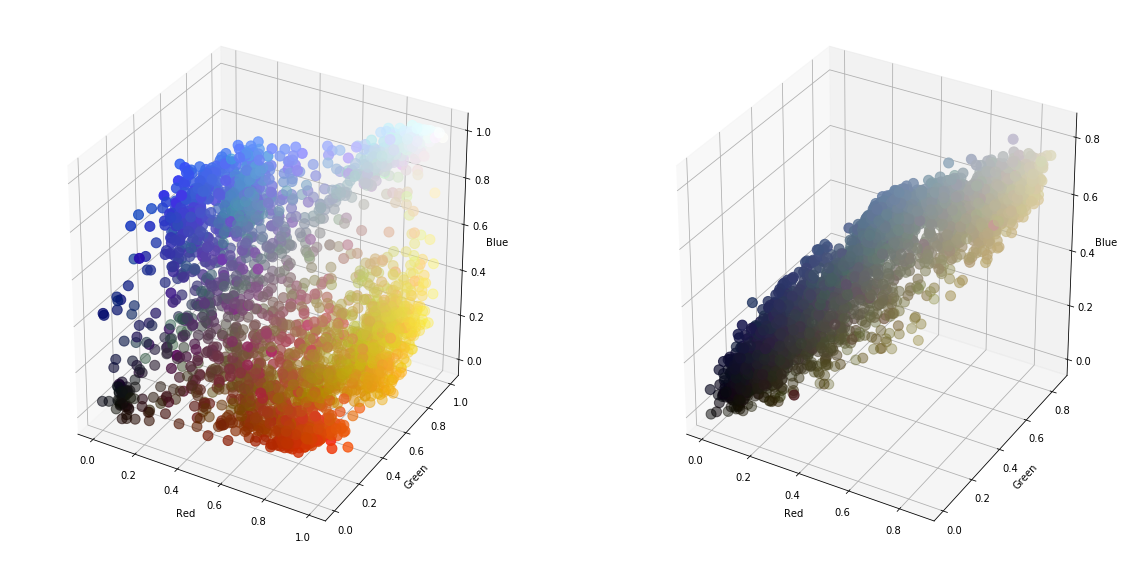

In [16]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,)) # sample random pixels
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=Xs,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

In [30]:
X = u.reshape((nru*ncu,3))
Y = v.reshape((nrv*ncv,3))
k = 15 # number of classes
ninit = 1
K0,K1 = k,k
gmmX = sklearn.mixture.GaussianMixture(n_components=K0, covariance_type='full',n_init=ninit).fit(X) # spherical or full 
pi0,mu0,S0 = gmmX.weights_, gmmX.means_, gmmX.covariances_ 
ClassesX = gmmX.predict(X) 
ProbaClassesX = gmmX.predict_proba(X) 

gmmY = sklearn.mixture.GaussianMixture(n_components=K1, covariance_type='full',n_init=ninit).fit(Y)  # spherical or full 
pi1,mu1,S1 = gmmY.weights_, gmmY.means_, gmmY.covariances_ 
ClassesY = gmmY.predict(Y) 
ProbaClassesY = gmmY.predict_proba(Y)

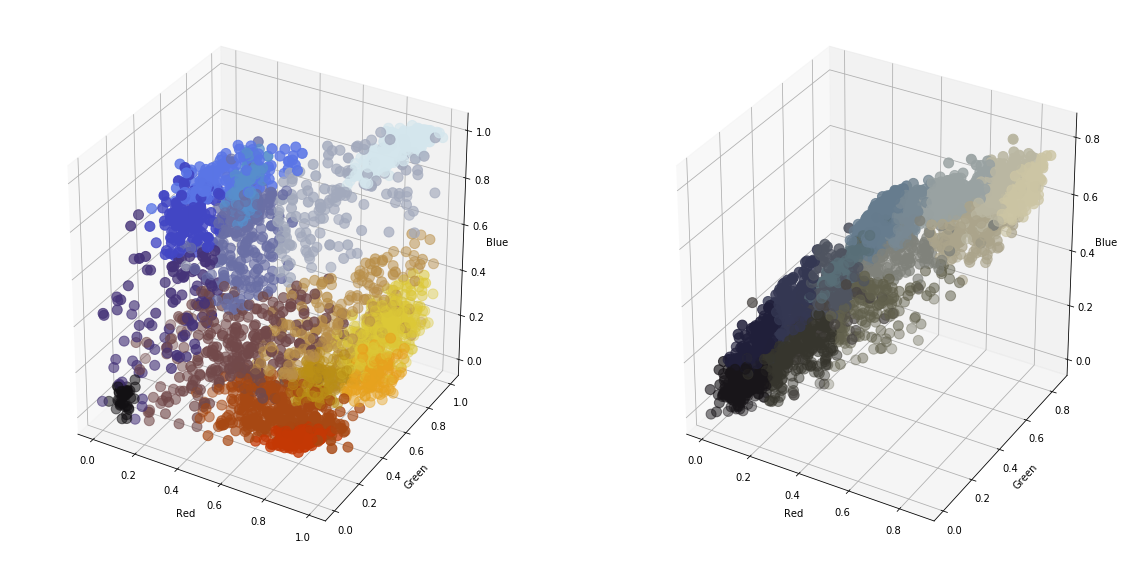

In [31]:
nb   = 3000
r    = np.random.RandomState(42)
idX  = r.randint(X.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Xs   = X[idX, :]
Ys   = Y[idY, :]
ClassesXsubsample = ClassesX[idX]
ClassesYsubsample = ClassesY[idY]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Xs[:, 0], Xs[:,1],Xs[:, 2], c=mu0[ClassesXsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=mu1[ClassesYsubsample,:],s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");

In [32]:
# Compute the K0xK1 OT matrix between the members of the mixtures
wstar,dist,_ = GW2(pi0/np.sum(pi0),pi1/np.sum(pi1),mu0,mu1,S0,S1)

# Compute all Tkl maps at all points of u 
T = np.zeros((K0,K1,3,nru*ncu))
for k in range(K0):
        for l in range(K1):
            T[k,l,:,:] = GaussianMap(mu0[k,:],mu1[l,:],S0[k,:,:],S1[l,:,:],X).T   
            
# Compute mean color transfer on all points
Tmeanx = np.zeros((3,nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmeanx += wstar[k,l]/pi0[k]*ProbaClassesX[:,k].T*T[k,l,:,:]
                
# Compute random color transfer on all points (random sample with posterior distribution)
#Trandx = np.zeros((3,nru*ncu))
#tmp = np.zeros((K0*K1,nru*ncu))
#for k in range(K0):
#    for l in range(K1):
#        tmp[k+K0*l,:]= wstar[k,l]/pi0[k]*ProbaClassesX[:,k]
#for i in range(nru*ncu):
#    m = np.random.choice(K0*K1,p=tmp[:,i])
#    l = m//K0
#    k = m - K0*l
#    Trandx[:,i] = T[k,l,:,i]        

    
# Compute best color transfer on all points (only best class for each point)
Tmaxx = np.zeros((3,nru*ncu))
normalisation = np.zeros((nru*ncu))
for k in range(K0):
    for l in range(K1):
        Tmaxx += wstar[k,l]*T[k,l,:,:]*(ClassesX==k).T
        normalisation +=wstar[k,l]*(ClassesX==k).T
Tmaxx = Tmaxx/normalisation


# Display result as an image
w=Tmeanx.T.reshape((nru,ncu,3))
wmax=Tmaxx.T.reshape((nru,ncu,3))
#wrand=Trandx.T.reshape((nru,ncu,3))


#we display the images
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 20))
#axes[0].imshow(np.clip(w,0,1))
#axes[0].set_title('w')
#axes[1].imshow(np.clip(wrand,0,1))
#axes[1].set_title('wrand')
#axes[2].imshow(np.clip(wmax,0,1))
#axes[2].set_title('wmax')
#fig.tight_layout()

In [33]:
w.min(), w.max()

(-0.027741891528631955, 0.8736774007005974)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


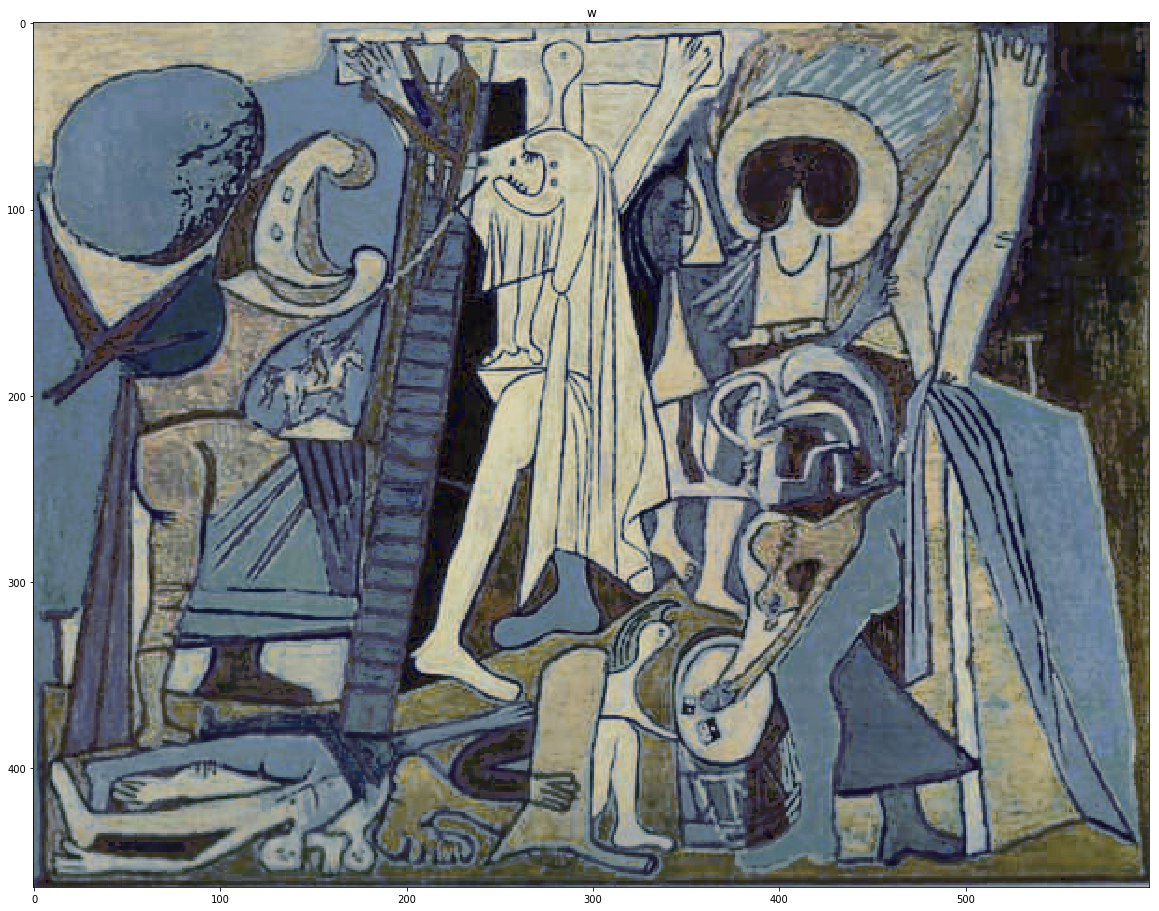

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow(w)
axes.set_title('w')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow(w)
axes.set_title('w')
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
axes.imshow(wmax)
axes.set_title('w')
plt.show()

In [ ]:
W = np.clip(w,0,1).reshape((nru*ncu,3))
nb   = 3000
r    = np.random.RandomState(42)
idW  = r.randint(W.shape[0], size=(nb,))
idY  = r.randint(Y.shape[0], size=(nb,))
Ws   = W[idW, :]
Ys   = Y[idY, :]

fig  = plt.figure(2, figsize=(20, 10))
axis = fig.add_subplot(1, 2, 1, projection="3d")
axis.scatter(Ws[:, 0], Ws[:,1],Ws[:, 2], c=Ws,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");
axis = fig.add_subplot(1, 2, 2, projection="3d")
axis.scatter(Ys[:, 0], Ys[:,1],Ys[:, 2], c=Ys,s=100)
axis.set_xlabel("Red"), axis.set_ylabel("Green"), axis.set_zlabel("Blue");